# Perspective Shift Identification

### Goal: 
Use ML to identify perspective shift in movement of distribution centers

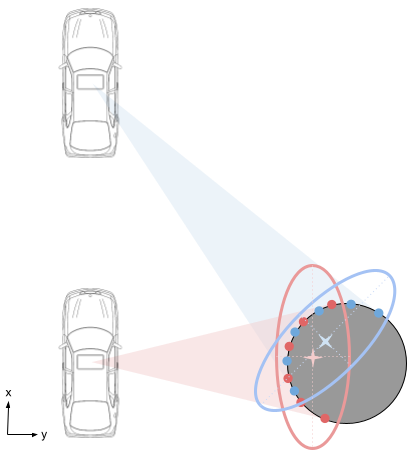

### Assumptions:
Gross rotation and translation have already been estimated by previous scan matching iterations

### Network structure:
Inputs: 
xyz of 25 points randomly sampled from each distribution

Output:
Correction factor translation between the two centers



### Training data generation

(starting with toy example)

1- generate grid of simple shapes in Inventor

2- Rotate randomly, translate randomly and simulate lidar scan of shapes at 2 points in time using MatLab script

3- Sample 25 points from each object and save to file. Also store information on rotation and translation to seperate file

4- import data here and augment again by duplicating and scaling examples arbitrarily

In [1]:
#setup - rememeber to switch to tensorflow 2.3 kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Derm\anaconda3\envs\tf23\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


2.3.0


Autosaving every 180 seconds


In [2]:
#using tf.dataset API

pc_ds = tf.data.Dataset.list_files("E:/datasets/point_cloud/*")
for dat in pc_ds:
    print(dat)

tf.Tensor(b'E:\\datasets\\point_cloud\\ICET_KITTI_FULL_scan1_to4500.npy', shape=(), dtype=string)
tf.Tensor(b'E:\\datasets\\point_cloud\\ICET_KITTI_FULL_ground_truth_to4500.npy', shape=(), dtype=string)
tf.Tensor(b'E:\\datasets\\point_cloud\\ICET_KITTI_FULL_scan2_to4500.npy', shape=(), dtype=string)


In [3]:
#save scan to npy file so we don't have to deal with loading large text files
# np.save("C:/Users/Derm/Desktop/big/pshift/s1", d1)
# np.save("C:/Users/Derm/Desktop/big/pshift/s2", d2)
# np.save("C:/Users/Derm/Desktop/big/pshift/gt", gt)

#large training set
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan1_to4500.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan2_to4500.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_ground_truth_to4500.npy")
# d1 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan1_to400.npy")
# d2 = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_scan2_to400.npy")
# gt = np.load("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_FULL_ground_truth_to400.npy")

#matlab synthetic point clouds
# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan1_10k.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan2_10k.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ground_truth_10k.txt")
# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan1_10k_100_samples.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan2_10k_100_samples.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ground_truth_10k_100_samples.txt")
# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan1_10k_50_samples.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan2_10k_50_samples.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ground_truth_10k_50_samples.txt")

d1 = np.load("C:/Users/Derm/Desktop/big/pshift/scan1_10k_50_samples.npy")
d2 = np.load("C:/Users/Derm/Desktop/big/pshift/scan2_10k_50_samples.npy")
gt = np.load("C:/Users/Derm/Desktop/big/pshift/ground_truth_10k_50_samples.npy")

# n2keep = 500000
# d1 = d1[:n2keep*25,:]
# d2 = d2[:n2keep*25,:]
# gt = gt[:n2keep,:]


print(np.shape(d1))
print(np.shape(d2))
print(np.shape(gt))

(8000000, 3)
(8000000, 3)
(160000, 3)


In [4]:
# d1 = d1[:500000, :]
# d2 = d2[:500000, :]
# gt = gt[:10000,:]
# print(np.shape(d1))
# print(np.shape(d2))
# print(np.shape(gt))

# print(np.save.__doc__)
# np.save("C:/Users/Derm/Desktop/big/pshift/scan1_10k_50_samples", d1)
# np.save("C:/Users/Derm/Desktop/big/pshift/scan2_10k_50_samples", d2)
# np.save("C:/Users/Derm/Desktop/big/pshift/ground_truth_10k_50_samples", gt)


In [5]:
#import training data
#toy data set
# d1 = np.loadtxt('training_data/scan1.txt')
# d2 = np.loadtxt('training_data/scan2.txt')
# gt = np.loadtxt('training_data/ground_truth.txt')

## slightly larger prism dataset
# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan1_10k.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/scan2_10k.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ground_truth_10k.txt")

#KITTI real world data
# d1 = np.loadtxt('training_data/ICET_KITTI_scan1.txt')
# d2 = np.loadtxt('training_data/ICET_KITTI_scan2.txt')
# gt = np.loadtxt('training_data/ICET_KITTI_ground_truth.txt')

# d1 = np.loadtxt('training_data/ICET_KITTI_scan1_25_shifted.txt')
# d2 = np.loadtxt('training_data/ICET_KITTI_scan2_25_shifted.txt')
# gt = np.loadtxt('training_data/ICET_KITTI_ground_truth_25_shifted.txt')

# NEW 7/28/22
#50 points per scan per cell ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# d1 = np.loadtxt('training_data/ICET_Ford_scan1.txt')
# d2 = np.loadtxt('training_data/ICET_Ford_scan2.txt')
# gt = np.loadtxt('training_data/ICET_Ford_ground_truth.txt')
# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_scan1.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_scan2.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_Ford_ground_truth.txt")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan1.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan2.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_ground_truth.txt")

# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan1_50.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan2_50.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_ground_truth_50.txt")

# d1 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan1_50_shifted.txt")
# d2 = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_scan2_50_shifted.txt")
# gt = np.loadtxt("C:/Users/Derm/Desktop/big/pshift/ICET_KITTI_ground_truth_50_shifted.txt")


# d1 = np.loadtxt("training_data/ICET_KITTI_FULL_scan1_to10.txt")
# d2 = np.loadtxt("training_data/ICET_KITTI_FULL_scan2_to10.txt")
# gt = np.loadtxt("training_data/ICET_KITTI_FULL_ground_truth_to10.txt")

# #combine two datasets
# d1 = np.append(d1, d1_2, axis = 0)
# d2 = np.append(d2, d2_2, axis = 0)
# gt = np.append(gt, gt_2, axis = 0)

points_per_sample = 50 #25 #50  #num pts per scan - defined in MatLab script
scan1 = tf.reshape(tf.convert_to_tensor(d1), [-1, points_per_sample, 3])
scan2 = tf.reshape(tf.convert_to_tensor(d2), [-1, points_per_sample, 3])
gt = tf.convert_to_tensor(gt)
# print(tf.shape(scan1))
# print(tf.shape(gt))

#split data into training and validation sets
tsplit = 0.95 #this fraction goes into training
ntrain = int(tsplit*tf.shape(scan1)[0].numpy())
x_train = tf.concat((scan1[:ntrain], scan2[:ntrain]), axis = 1)
x_test = tf.concat((scan1[ntrain:], scan2[ntrain:]), axis = 1)
y_train = gt[:ntrain]
y_test = gt[ntrain:]

# x_train = tf.reshape(x_train, [-1, 50, 1, 1, 1])
print(tf.shape(x_train))
# x_train = tf.reshape(x_train, [-1, 50, 3])

# print(x_train[0,0,:])

print(gt[:10])
print(gt[-10:])

print(y_train[:10])
print(y_test[-10:])

tf.Tensor([152000    100      3], shape=(3,), dtype=int32)
tf.Tensor(
[[-7.71014475e+00 -4.74378203e+00 -4.55012955e-01]
 [-5.46494984e+00  1.40353442e+01 -2.67684591e-01]
 [ 5.08337161e-01  9.46211553e+00  1.33753893e-01]
 [ 1.88618466e+01 -3.17239865e+00  4.73250902e-02]
 [-2.19628643e+00  1.01773077e+01  4.58809472e-02]
 [-5.03609606e+00  8.31366717e-01  2.63955950e-01]
 [-1.53177775e+01 -5.79236940e+00  1.76099138e-02]
 [ 8.82803450e+00 -1.54314064e+01 -2.31418660e-01]
 [-7.24802017e+00  1.47740119e+01  9.44182555e-02]
 [-1.23669741e+00 -6.70119701e+00 -1.64343186e-01]], shape=(10, 3), dtype=float64)
tf.Tensor(
[[-5.31078826e+00 -1.28289243e+01  2.88505510e-01]
 [-6.83671923e+00  4.37331362e+00  3.03240978e-01]
 [ 4.57186315e+00  7.01246554e+00  2.19521738e-01]
 [ 1.57380979e+01  6.44287848e+00 -7.22083809e-03]
 [-7.87273505e+00 -3.65943986e+00 -1.27665003e-01]
 [-1.79022513e+00 -6.55052524e+00 -8.75744292e-02]
 [-2.85640700e+00 -1.71701191e+01  6.06499228e-02]
 [-1.64406888e+00 -8

In [21]:
#train network
from network import Net
# from network import permNet as Net
# from network import PointNet as Net
# from network import PCRnet as Net
# np.random.seed(1337)

runLen = 300

def scheduler(epoch, learning_rate):
#     part1 = 2*runLen//3
#     part2 = 5*runLen//6 #net1

    part1 = runLen//3
    part2 = 2*runLen//3 #net2

    if epoch < part1:
        learning_rate = 0.002
        return learning_rate
    if epoch >= part1 and epoch < part2:
        learning_rate = 0.0005 #0.001
        return learning_rate
    if epoch >= part2:
        learning_rate = 0.0001 #0.00025
        return learning_rate

# model = Net()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss = tf.keras.losses.MeanAbsoluteError()) #was MeanSquaredError()

summary = model.summary()
print(summary)
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
cp = tf.keras.callbacks.ModelCheckpoint("KITTInetCP.kmod", monitor = 'val_loss', save_best_only = True) 

log_dir = "runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

trace = model.fit(x = x_train, y = y_train, batch_size = 256, epochs=runLen, verbose=1, 
                  validation_split = 0.2, shuffle=True, callbacks = [cp])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 3)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims_1 (Te (None, 100, 3, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 1, 64)        256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 1, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 1, 64)        4160      
_________________________________________________________________
batch_normalization_7 (Batch (None, 100, 1, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 1, 64)       

INFO:tensorflow:Assets written to: KITTInetCP.kmod\assets
475/475 [==============================] - 6s 12ms/step - loss: 0.6845 - val_loss: 0.4943
Epoch 5/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6826 - val_loss: 0.5761
Epoch 6/300
475/475 [==============================] - 4s 9ms/step - loss: 0.7056 - val_loss: 0.7185
Epoch 7/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6815 - val_loss: 2.1223
Epoch 8/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6841 - val_loss: 0.6852
Epoch 9/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6758 - val_loss: 0.6172
Epoch 10/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6758 - val_loss: 0.6053
Epoch 11/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6939 - val_loss: 1.0176
Epoch 12/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6847 - val_loss: 0.5219
Epoch 13/300
475/475 [===================

475/475 [==============================] - 4s 9ms/step - loss: 0.6711 - val_loss: 0.5319
Epoch 53/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6722 - val_loss: 0.6948
Epoch 54/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6680 - val_loss: 0.7232
Epoch 55/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6743 - val_loss: 0.6372
Epoch 56/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6605 - val_loss: 0.4881
Epoch 57/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6700 - val_loss: 0.4947
Epoch 58/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6765 - val_loss: 1.3976
Epoch 59/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6563 - val_loss: 0.5486
Epoch 60/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6762 - val_loss: 0.4982
Epoch 61/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6704 - val_loss: 

475/475 [==============================] - 5s 10ms/step - loss: 0.6518 - val_loss: 0.4984
Epoch 122/300
475/475 [==============================] - 5s 10ms/step - loss: 0.6482 - val_loss: 0.5470
Epoch 123/300
475/475 [==============================] - 5s 10ms/step - loss: 0.6595 - val_loss: 0.5377
Epoch 124/300
475/475 [==============================] - 5s 10ms/step - loss: 0.6435 - val_loss: 0.4918
Epoch 125/300
475/475 [==============================] - 5s 9ms/step - loss: 0.6445 - val_loss: 0.5728
Epoch 126/300
475/475 [==============================] - 4s 9ms/step - loss: 0.6617 - val_loss: 0.6005
Epoch 127/300
475/475 [==============================] - 5s 10ms/step - loss: 0.6624 - val_loss: 0.5186
Epoch 128/300
475/475 [==============================] - 5s 10ms/step - loss: 0.6470 - val_loss: 0.6289
Epoch 129/300
475/475 [==============================] - 5s 10ms/step - loss: 0.6518 - val_loss: 0.5492
Epoch 130/300
475/475 [==============================] - 5s 10ms/step - loss: 0.

KeyboardInterrupt: 

### Top Scores
#### C:/Users/Derm/Desktop/big/pshift/scan1_10k_50_samples.txt 

-- 0.69 MAE using the CNN kernel hack presented in PCR-Net

-- 0.60 MAE using my strategy

-- 0.41 MAE using simplified PCR-Net (saved as <Net.kmod>)


<IPython.core.display.Javascript object>


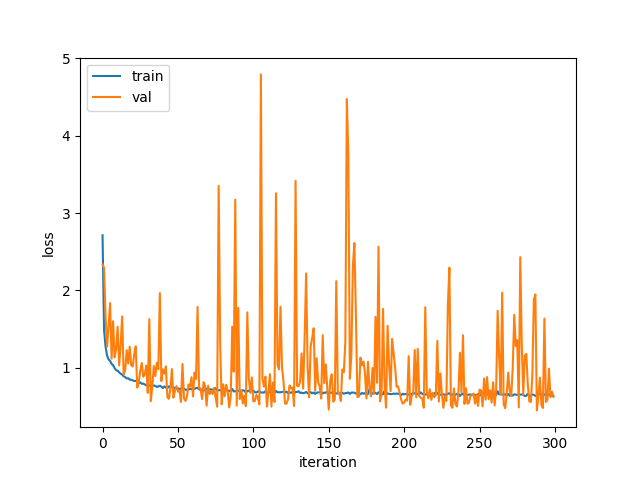

Text(0, 0.5, 'loss')

In [22]:
fig0, ax0 = plt.subplots()
ax0.plot(trace.history['loss'], '-')
ax0.plot(trace.history['val_loss'], '-')
ax0.legend(['train', 'val'], loc='upper left')
ax0.set_xlabel('iteration')
ax0.set_ylabel('loss')

In [23]:
# estimates = model.predict(x_train[0:100:16])
# print(estimates)
# print(y_train[0:100:16])
estimates = model.predict(x_test[:10])
print("estimated translation x y z")
print(estimates)
print("actual translation x y z")
print(y_test[:10])

err = y_test[:10] - estimates
# err = y_train[0:100:16] - estimates

print("\n Error \n",err)

print(tf.math.reduce_mean(tf.math.reduce_sum(err, axis = 1)))




Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
estimated translation x y z
[[-13.334242    -5.555015     0.04869303]
 [  3.3968585    0.53313667   0.06184171]
 [ -9.532051    -4.434994     0.05183525]
 [ 18.866562   -16.236092     0.07614981]
 [ 11.670136    -6.759581     0.06841749]
 [ 10.187805     3.5579734    0.06712227]
 [  4.2158017   -3.1664944    0.06233916]
 [  4.3072233   -1.0287251    0.06250899]
 [

<IPython.core.display.Javascript object>


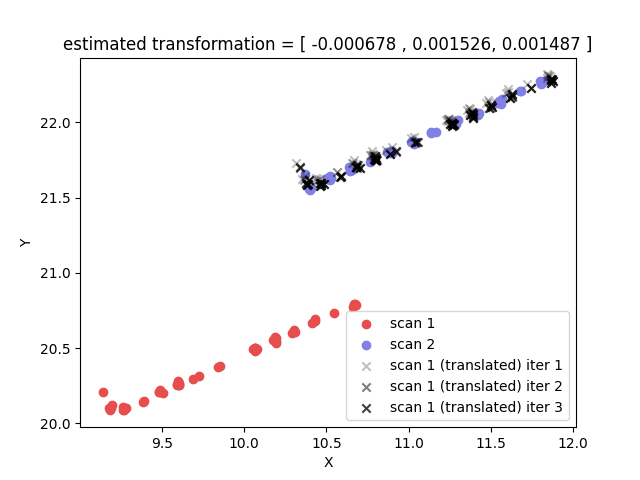

n =  142

 y_test tf.Tensor([12.01758664 14.96044748 -0.09474512], shape=(3,), dtype=float64)

 estiamted soln: [[1.19940824e+01 1.49378035e+01 1.20747788e-02]]


In [30]:
#visualize results of network on test data
#2d plots (x and y only)
fig1, ax1 = plt.subplots()
# n = 259 #sample number (from x_test)
n = int(np.floor(500*np.random.rand()))

print("n = ", n)

# print(tf.shape(x_test))
c1 = np.array([x_test[n,:points_per_sample,0].numpy(), x_test[n,:points_per_sample,1].numpy(), x_test[n,:points_per_sample,2].numpy()])
c2 = np.array([x_test[n,points_per_sample:,0].numpy(), x_test[n,points_per_sample:,1].numpy(), x_test[n,points_per_sample:,2].numpy()])
ax1.scatter(c1[0,:], c1[1,:], color = [0.9, 0.3, 0.3], label = 'scan 1')
ax1.scatter(c2[0,:], c2[1,:], color = [0.5, 0.5, 0.9], label = 'scan 2')


inputs = x_test[n][None,:]
runlen = 3
corr_sum = np.zeros([1,3]) #init var to store correction contributions
for i in range(runlen):
    correction = model.predict(inputs)[0] #show what the network thinks
    correction = correction*0.1
    corr_sum += correction
#     print(correction)
#     correction = 0.1*y_test[n] #show actual solution
    c1 = np.array([c1[0,:] + correction[0], c1[1,:] + correction[1], c1[2,:] + correction[2]])
    inputs = np.append(c1, c2, axis = 1).T[None,:,:]
    moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0., 0., 0., (i+1)/(runlen+1)],
                        label = 'scan 1 (translated) iter %i' %(i+1))

# moved = ax1.scatter(c1[0,:], c1[1,:], marker = 'x', color = [0.9, 0.3, 0.3, (i+2)/(runlen+2)],
#                         label = 'scan 1 (translated)')

ax1.set_title("estimated transformation = [ %f , %f, %f ]" %(correction[0], correction[1], correction[2]))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend(loc = 'best')

print("\n y_test", y_test[n])
print("\n estiamted soln:", corr_sum*10)


In [31]:
#use Vedo to plot inital and transformed point clouds in 3D 
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []

#draw scan1 
disp.append(Points(x_test[n,:points_per_sample].numpy(), c = 'green', r = 5))

#draw initial scan2
disp.append(Points(x_test[n,points_per_sample:].numpy(), c = 'red', r = 5))

#draw transformed scan2
disp.append(Points(c1, c = 'blue', r = 5))

plt1.show(disp, "Network Performance Test")
ViewInteractiveWidget(plt1.window)



ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [27]:
#save network
# model.save("ffnet10k25.kmod")
# model.save("Net.kmod")
# model.save("PIPEnet10.kmod")
# model.save("KITTInet.kmod")
# model.save("FordNet.kmod")
# model.save("FULL_KITTInet4500.kmod")


#load network
model = tf.keras.models.load_model("Net.kmod")
# model = tf.keras.models.load_model("PIPEnet10.kmod")
# model = tf.keras.models.load_model("KITTInet.kmod")
# model = tf.keras.models.load_model("FORDnetCP.kmod")

In [ ]:
#test random shuffle layer to enforce training on unordered data
#GOAL: randomize order of each sample in batch SEPRATELY 
#      (i.e. don't have same order for all elements of batch)

test = tf.constant([[1., 3., 4.], [2., 3., 5.], [6., 6., 6.], [0., 0., 0.]])#[None, :, :]
test = tf.Variable([test, 2*test])
print(test)

test = tf.transpose(test, [1,0,2])
test = tf.random.shuffle(test)
test = tf.transpose(test, [1,0,2])
print(test)

### Top scores:

#### 1k dataset
8.23 MSE with no parallelization (vel = [5, 5, 5])

4.2 MSE (vel = [5, 5, 0.01])

3.9 MSE - 50 sample points from each scan

3.34- maxpool on first/ second half, conv after


#### 10k dataset

2.4 MSE 50 samples

1.05 MSE 25 samples -ffNet10k25.kmod

### KITTI drive 005, 100 frames

0.145 - Permnet

0.0895 -PCRnet

0.0520 KITTInet (5/20)

### KITTI drive 005, 150 frames, 50 sample points
0.759 pipeNET

### Ford Campus Drive 01 (200 frame sample)
0.073 - NET, 200 frames, with ground plane

### KITTI Full 00 400 frames, with ground plane
0.0752 net

### KITTI Full 00 400 frames, no ground plane
0.0756

### KITTI Full 00 4500 frames, with ground plane
0.0736 net


### Notes
From PointNet: Small rotations and gaussian noise can successfully augment models to increase training dataset

Need to figure out a way to achieve permutation invariance
Try transformer network i.e. "Attention is all you need"
https://ai.googleblog.com/2021/11/permutation-invariant-neural-networks.html

Can potentially use reflectance as 4th dimension(?)

In [ ]:
8**3 